In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import setup
import parse
import utils
import train

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping
from sklearn.model_selection import train_test_split, KFold

#### Load original dataset and plot score distribution

<Axes: ylabel='Frequency'>

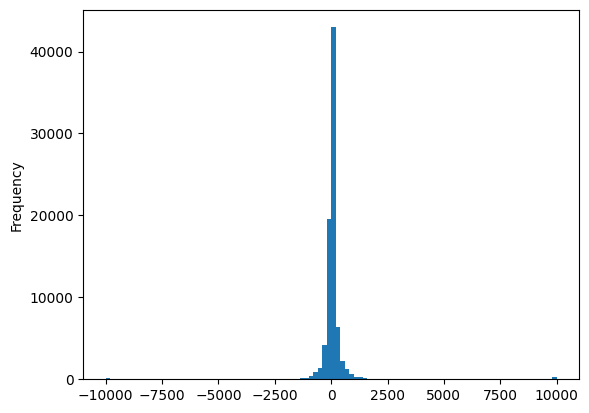

In [2]:
df = pd.read_csv(setup.DATASET_DIR+setup.DATASET_REGULAR, nrows=setup.N_ROWS*setup.DATASET_REGULAR_SIZE, dtype={"Fen": np.string_, "Evaluation": np.string_})
df["Evaluation"] = df["Evaluation"].apply(lambda x: parse.stockfish_eval_to_int(x))
df["Evaluation"].plot.hist(bins=100)

#### Random

<Axes: ylabel='Frequency'>

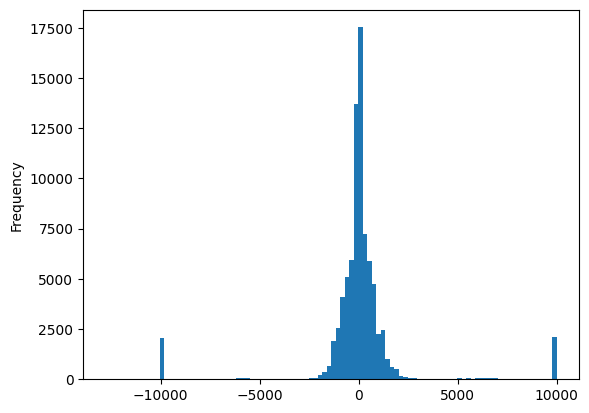

In [3]:
df_random = pd.read_csv(setup.DATASET_DIR+setup.DATASET_RANDOM, nrows=setup.N_ROWS*setup.DATASET_RANDOM_SIZE, dtype={"Fen": np.string_, "Evaluation": np.string_})
df_random["Evaluation"] = df_random["Evaluation"].apply(lambda x: parse.stockfish_eval_to_int(x))
df_random["Evaluation"].plot.hist(bins=100)

#### Tactics

<Axes: ylabel='Frequency'>

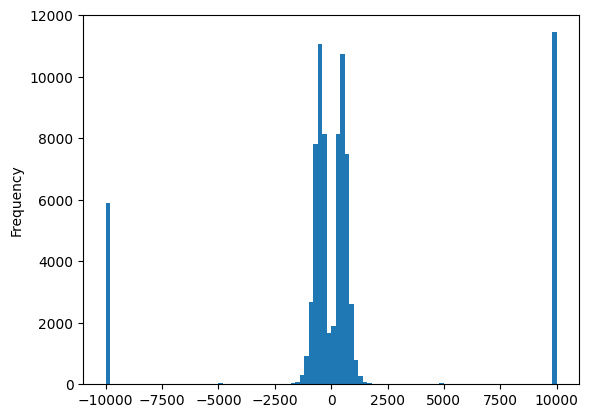

In [4]:
df_tactic = pd.read_csv(setup.DATASET_DIR+setup.DATASET_TACTIC, nrows=setup.N_ROWS*setup.DATASET_TACTIC_SIZE, dtype={"Fen": np.string_, "Evaluation": np.string_}, usecols=[0, 1])
df_tactic["Evaluation"] = df_tactic["Evaluation"].apply(lambda x: parse.stockfish_eval_to_int(x))
df_tactic["Evaluation"].plot.hist(bins=100)

#### Total dataset

<Axes: ylabel='Frequency'>

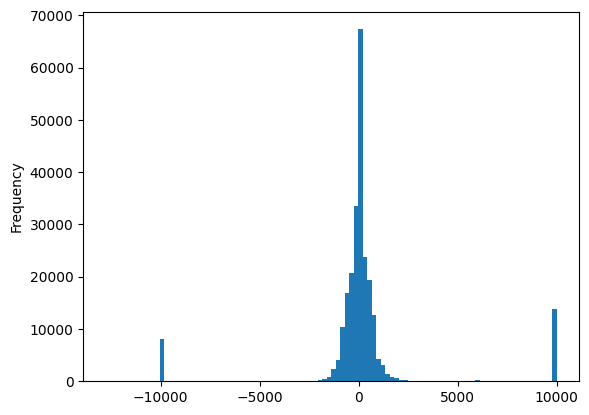

In [5]:
pd.concat([df, df_random, df_tactic])["Evaluation"].plot.hist(bins=100)

In [6]:
del df, df_random, df_tactic

#### Load vectorized dataset and plot normalized score

<Axes: ylabel='Frequency'>

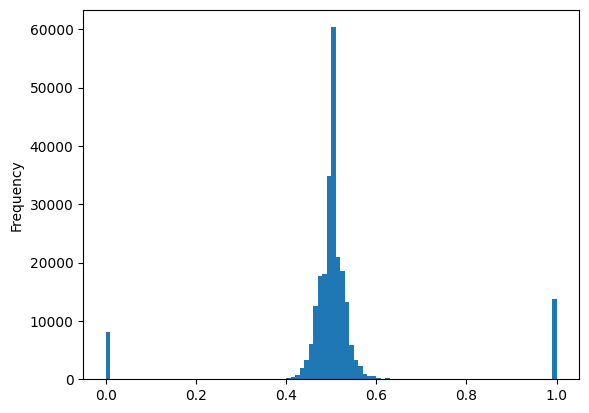

In [2]:
df_vectorized = pd.read_csv(setup.DATASET_DIR+setup.DATASET_VECTORIZED)
df_vectorized["label"].plot.hist(bins=100)

In [3]:
df_vectorized

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_760,f_761,f_762,f_763,f_764,f_765,f_766,f_767,f_768,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49950
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50280
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49955
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50260
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
247496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48630
247497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48520
247498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000


In [4]:
# Check for null values
assert df_vectorized[df_vectorized.isnull().values].empty
# Check shape (+1 is for the label)
assert df_vectorized.shape == (setup.N_ROWS_EFFECTIVE, setup.N_FEATURES + 1)

### Train the model

In [5]:
model, (history, train_error, cv_error) = train.create_model_and_train(df_vectorized)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              787456    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4

2023-02-16 22:03:38.265752: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


792/792 [==============================] - 23s 29ms/step - loss: 0.0943 - val_loss: 0.0268
Epoch 2/40
792/792 [==============================] - 22s 28ms/step - loss: 0.0212 - val_loss: 0.0209
Epoch 3/40
792/792 [==============================] - 23s 28ms/step - loss: 0.0175 - val_loss: 0.0264
Epoch 4/40
792/792 [==============================] - 23s 29ms/step - loss: 0.0161 - val_loss: 0.0264
Epoch 5/40
792/792 [==============================] - 23s 30ms/step - loss: 0.0148 - val_loss: 0.0194
Epoch 6/40
792/792 [==============================] - 24s 31ms/step - loss: 0.0137 - val_loss: 0.0214
Epoch 7/40
792/792 [==============================] - 24s 30ms/step - loss: 0.0126 - val_loss: 0.0208
Epoch 8/40
792/792 [==============================] - 24s 30ms/step - loss: 0.0116 - val_loss: 0.0179
Epoch 9/40
792/792 [==============================] - 24s 30ms/step - loss: 0.0107 - val_loss: 0.0166
Epoch 10/40
792/792 [==============================] - 24s 30ms/step - loss: 0.0099 - val_los

### Evaluate error and plot learning curve

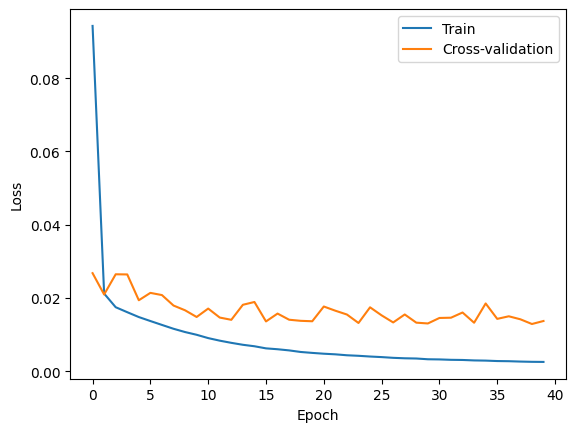

Training set error: 0.0028
Cross-validation set error: 0.014
Random classifier error: 0.11


In [6]:
utils.plot_learning_curve(history)
y_cv = df_vectorized["label"]
print(f"Training set error: {train_error:.2}")
print(f"Cross-validation set error: {cv_error:.2}")
print(f"Random classifier error: {((np.random.rand(len(y_cv)) - y_cv)**2).mean():.2}")

In [11]:
if setup.SAVE_MODEL:
    model.save(setup.MODEL_NAME)

INFO:tensorflow:Assets written to: models/latest/assets


INFO:tensorflow:Assets written to: models/latest/assets


In [12]:
if setup.K_FOLD:
    features = [f"f_{str(x)}" for x in range(1, setup.N_FEATURES+1)]
    k_fold = KFold(n_splits=setup.N_FOLDS)
    train_error_all = []
    cv_error_all = []
    X = df_vectorized[features]
    y = df_vectorized["label"]

    # TODO reset index first?
    for i, (train, test) in enumerate(k_fold.split(X, y)):
        model = create_model()
        _, train_error, cv_error = train_evaluate_model(model, X.loc[train], y.loc[train], X.loc[test], y.loc[test])
        train_error_all.append(train_error)
        cv_error_all.append(cv_error)
        print(f"Model #{i+1} done! CV error: {cv_error:.2}")
        del model

    print(f"Training sets error:{train_error_all}")
    print(f"Cross-validation sets sets errors:{cv_error_all}")
    print(f"Training sets mean error: {np.mean(np.array(train_error_all)):.2}")
    print(f"Cross-validation sets mean error: {np.mean(np.array(cv_error_all)):.2}")